# Define Events and Prep Event Data

In [1]:
%load_ext version_information

In [2]:
import datetime
from pprint import pprint

import spacepy.plot as spp
import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacepy import omni
from spacepy import time as spt
from spacepy import plot as spp
spp.revert_style()
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
import tqdm
from scipy import stats
import matplotlib
from sklearn.neighbors import KDTree
from spacepy import omni as omni
from spacepy import toolbox as tb
from spacepy import time as spt
from spacepy import datamodel as dm
import scipy
import h5py

import verify

%version_information numpy, matplotlib, version_information, verify, scipy, sklearn, seaborn, spacepy, h5py

This unreleased version of SpacePy is not supported by the SpacePy team.
Qin-Denton/OMNI2 data not found in current format. This module has limited functionality.
Run spacepy.toolbox.update(QDomni=True) to download data


/Users/balarsen/miniconda3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Software,Version
Python,3.7.0 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython,7.0.1
OS,Darwin 17.7.0 x86_64 i386 64bit
numpy,1.15.2
matplotlib,3.0.0
version_information,1.0.3
verify,The 'verify' distribution was not found and is required by the application
scipy,1.1.0
sklearn,0.20.0
seaborn,0.9.0


# Load in Onni data and define events
* OMNI needed on 8 hour cadence
* Times are given as bin start times

In [4]:
# tb.update(omni=True, omni2=True)

Retrieving Qin_Denton file ...
Download Progress ...100%

Now processing (this may take a minute) ...


/Users/balarsen/miniconda3/lib/python3.7/site-packages/spacepy/time.py:228: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(dtype, collections.Callable):


Now saving... 
Retrieving OMNI2 file ...
Download Progress ...100%



'/Users/balarsen/.spacepy/data'

In [5]:
# need ticktocks over the time interval to her 8 hour averaged OMNI
# CXD data 2001-03-05 00:00:00'), Timestamp('2016-10-31 16:00:00'
times = pd.DatetimeIndex(start='2002-01-01', end='2016-03-01', freq='8H')
tt_times = spt.Ticktock(times.to_pydatetime())
pprint(tt_times[0:4])

Ticktock( [datetime.datetime(2002, 1, 1, 0, 0) datetime.datetime(2002, 1, 1, 8, 0)
 datetime.datetime(2002, 1, 1, 16, 0) datetime.datetime(2002, 1, 2, 0, 0)], dtype=UTC)


In [6]:
# get the omni data
om = omni.get_omni(tt_times)
om.keys()

dict_keys(['ByIMF', 'Bz1', 'Bz2', 'Bz3', 'Bz4', 'Bz5', 'Bz6', 'BzIMF', 'DOY', 'Dst', 'G', 'Kp', 'Pdyn', 'RDT', 'W', 'akp3', 'dens', 'velo', 'ticks', 'UTC', 'Hr', 'Year', 'Qbits'])

In [7]:
# build a pandas dataframe of the Omnni data
keys = ['BzIMF', 'Dst', 'Kp', 'Pdyn', 'akp3', 'dens', 'velo', ] # 'ticks']

om_df = pd.DataFrame(data=om[keys])
om_df.index = pd.DatetimeIndex(om['ticks'].UTC)
om_df.head()

,BzIMF,Dst,Kp,Pdyn,akp3,dens,velo
2002-01-01 00:00:00,-1.1,-38.0,2.3,1.35,3.55,3.2,459.0
2002-01-01 08:00:00,0.9,-48.0,2.3,1.80,2.45,4.4,468.0
2002-01-01 16:00:00,0.2,-32.0,1.0,1.05,1.22,3.0,418.0
2002-01-02 00:00:00,-1.9,-14.0,2.0,1.29,2.02,4.0,402.0
2002-01-02 08:00:00,0.5,-16.0,1.0,1.51,1.13,4.1,413.0


In [8]:
om_df.dropna(inplace=True)

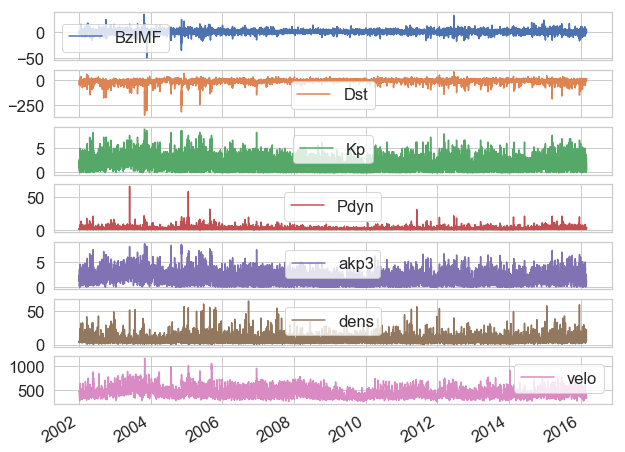

In [9]:
om_df.plot(figsize=(10,8), subplots=True);

## Need to get some events
* define 10 events, 5 storm and 5 non storm

In [10]:
np.random.seed(8675309)
storm_events = om_df.loc[om_df['Dst'] < -75, :].sample(5).index.to_pydatetime()
quiet_events = om_df.loc[om_df['Dst'] > -20, :].sample(5).index.to_pydatetime()
events = np.hstack((storm_events, quiet_events))
events.sort()
events

# array([datetime.datetime(2002, 1, 28, 16, 0),
#        datetime.datetime(2002, 4, 20, 16, 0),
#        datetime.datetime(2002, 10, 8, 0, 0),
#        datetime.datetime(2003, 8, 18, 8, 0),
#        datetime.datetime(2004, 1, 22, 16, 0),
#        datetime.datetime(2004, 11, 8, 16, 0),
#        datetime.datetime(2006, 7, 7, 8, 0),
#        datetime.datetime(2013, 5, 10, 16, 0),
#        datetime.datetime(2013, 9, 16, 0, 0),
#        datetime.datetime(2015, 6, 20, 0, 0)], dtype=object)

array([datetime.datetime(2002, 1, 28, 16, 0),
       datetime.datetime(2002, 4, 20, 16, 0),
       datetime.datetime(2002, 10, 8, 0, 0),
       datetime.datetime(2003, 8, 18, 8, 0),
       datetime.datetime(2004, 1, 22, 16, 0),
       datetime.datetime(2004, 11, 8, 16, 0),
       datetime.datetime(2006, 7, 7, 8, 0),
       datetime.datetime(2013, 5, 10, 16, 0),
       datetime.datetime(2013, 9, 16, 0, 0),
       datetime.datetime(2015, 6, 20, 0, 0)], dtype=object)

## Now grab all the omni parameters for the events for easy plotting later on
* this can be done from the vectors
* we need 7 days before and 21 days after

In [11]:
with h5py.File('../Data/OMNI_Vectors.h5', 'r') as h5:
    print(list(h5.keys()))
    omni_keys = list(h5.keys())
    omni_keys

['BzIMF', 'BzIMF_std', 'Dst', 'Dst_std', 'Kp', 'Kp_std', 'Pdyn', 'Pdyn_std', 'akp3', 'akp3_std', 'dens', 'dens_std', 'velo', 'velo_std']


In [12]:
omni_keys

['BzIMF',
 'BzIMF_std',
 'Dst',
 'Dst_std',
 'Kp',
 'Kp_std',
 'Pdyn',
 'Pdyn_std',
 'akp3',
 'akp3_std',
 'dens',
 'dens_std',
 'velo',
 'velo_std']

In [13]:
omni_data = {}
for k in tqdm.tqdm_notebook(omni_keys):
    omni_data[k] = pd.read_hdf('../Data/OMNI_Vectors.h5', k)

In [14]:
omni_data['Kp'].head()

,-176,-168,-160,-152,-144,-136,-128,-120,-112,-104,...,-72,-64,-56,-48,-40,-32,-24,-16,-8,0
2001-01-08 08:00:00,0.0,1.0,0.3,1.3,0.0,0.3,2.3,2.3,0.7,2.3,...,0.7,0.3,2.0,1.0,1.0,2.0,1.3,1.0,2.0,1.0
2001-01-08 16:00:00,1.0,0.3,1.3,0.0,0.3,2.3,2.3,0.7,2.3,3.0,...,0.3,2.0,1.0,1.0,2.0,1.3,1.0,2.0,1.0,2.0
2001-01-09 00:00:00,0.3,1.3,0.0,0.3,2.3,2.3,0.7,2.3,3.0,3.0,...,2.0,1.0,1.0,2.0,1.3,1.0,2.0,1.0,2.0,2.0
2001-01-09 08:00:00,1.3,0.0,0.3,2.3,2.3,0.7,2.3,3.0,3.0,1.7,...,1.0,1.0,2.0,1.3,1.0,2.0,1.0,2.0,2.0,1.0
2001-01-09 16:00:00,0.0,0.3,2.3,2.3,0.7,2.3,3.0,3.0,1.7,0.7,...,1.0,2.0,1.3,1.0,2.0,1.0,2.0,2.0,1.0,1.0


Trail and error led to the formula to pull out a time series from the vectors. Now and 7 days part is simply:

omni_data['Kp'].loc[events[0]]

To get the next 7 days forward it is:

omni_data['Kp'].loc[events[0]+pd.Timedelta(days=7, hours=16)]

And the general formaula is 

omni_data['Kp'].loc[events[0]+pd.Timedelta(days=7*n, hours=16*n)]   where n=1,2,3


In [15]:
def build_data_from_vector(indat, time, daysout=3, CXD_std=False):
    """
    given imput vectors build the time series of the data for the event
    
    CXD_std has two more columns that need to be left out
    """
    ans = []
    for i in range(0, daysout+1):
        if CXD_std:
            ans.extend(indat.loc[time+pd.Timedelta(days=7*i, hours=16*i)][:-2])
        else:
            ans.extend(indat.loc[time+pd.Timedelta(days=7*i, hours=16*i)])
    ans = np.asarray(ans)
    T0 = time - pd.Timedelta(hours=176)
    times = pd.DatetimeIndex([T0 + pd.Timedelta(hours=8*v) for v in range(len(ans))])
    return pd.Series(ans, index=times)
    

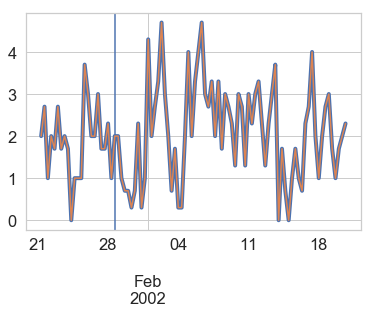

In [16]:
s = build_data_from_vector(omni_data['Kp'], events[0])
s.plot(lw=4)
plt.axvline(events[0])
events[0]
om_df['Kp'].loc[s.index[0]:s.index[-1]].plot()
assert (s == om_df['Kp'].loc[s.index[0]:s.index[-1]]).all()

### Read in the CXD vectors and add them in

In [17]:
vectors_Log_Flux_std = pd.read_hdf('../Data/CXD_Vectors.h5', 'vectors_Log_Flux_std')
vectors_Log_Flux = pd.read_hdf('../Data/CXD_Vectors.h5', 'vectors_Log_Flux')

In [18]:
event_data = {}
for ii, e in enumerate(tqdm.tqdm_notebook(events)):
    event_data[e] = {}
    for k in omni_data:
        event_data[e][k] = build_data_from_vector(omni_data[k], e)
        event_data[e]['vectors_Log_Flux_std'] = build_data_from_vector(vectors_Log_Flux_std, e, CXD_std=True)
        event_data[e]['vectors_Log_Flux'] = build_data_from_vector(vectors_Log_Flux, e)
        

KeyError: 'the label [2002-04-20 16:00:00] is not in the [index]'

In [ ]:
tb.dictree(event_data, levels=2
          )